# Heston Model Calibration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import * 
from scipy.stats import norm
from scipy.optimize import fmin_bfgs
from scipy import *
from scipy.integrate import quad
from scipy import optimize

In [4]:
# Heston model solution
def heston_call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    p1 = p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)
    p2 = p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)
    return (s0*p1-K*exp(-r*T)*p2)

def p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    integrand = lambda phi: (exp(-1j*phi*log(K))* 
    f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status)/(1j*phi)).real    
    return (0.5+(1/pi)*quad(integrand,0,100)[0])

def f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status): 
    if status==1:
        u = 0.5
        b = kappa-rho*sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa*theta
    x = log(s0)
    d = sqrt((rho*sigma*phi*1j-b)**2-sigma**2*(2*u*phi*1j-phi**2))
    g = (b-rho*sigma*phi*1j+d)/(b-rho*sigma*phi*1j-d)
    C = r*phi*1j*T+(a/sigma**2)*((b-rho*sigma*phi*1j+d)*T-2*log((1-g*exp(d*T))/(1-g)))
    D = (b-rho*sigma*phi*1j+d)/sigma**2*((1-exp(d*T))/(1-g*exp(d*T)))
    return exp(C+D*v0+1j*phi*x)


In [5]:
# Calibration(kappa, theta, sigma, rho, v0)
def calibrate(init_val, market_datas):
    def error(x):
        kappa, theta, sigma, rho, v0 = x
        print('x=',kappa, theta, sigma, rho, v0)
        result = 0.0
        for i in range(0,len(market_datas)):
            s0, k, market_price, r, T = market_datas.iloc[i]
            #print(s0, k, market_price, r, T)
            heston_price = heston_call_price(kappa, theta, sigma, rho, v0, r, T, s0, k)
            result += (heston_price - market_price)**2
            
        print('result',result)
        return result
    opt=optimize.least_squares(error,init_val)# ??? or fmin, or leastsq
    return opt

In [6]:
# Load market data
# S0  K  Call_Price  r  T
market_datas=pd.read_csv('marketdata.csv')

In [7]:
# Initialize kappa, theta, sigma, rho, v0
init_val = [1.1,0.1,0.4,-0.0,0.1]

# Calibration of parameters
opt = calibrate(init_val, market_datas) #very slow!!!!!
kappa, theta, sigma, rho, v0=opt

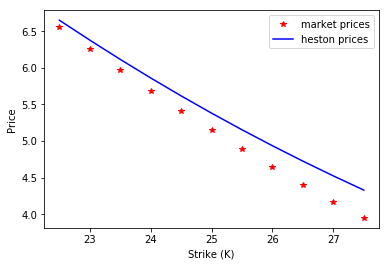

In [8]:
# Compute Heston prices using optimized params
market_prices = np.array([])
heston_prices = np.array([])
K = np.array([])
for i in range(0,len(market_datas)):
    s0, k, market_price, r, T = market_datas.iloc[i] 
    heston_prices = np.append(heston_prices, heston_call_price(kappa, theta, sigma, rho, v0, r, T, s0, k))
    market_prices = np.append(market_prices, market_price)
    K = np.append(K,k)

#plot result
plt.plot(K, market_prices, 'r*',label='market prices')
plt.plot(K, heston_prices, 'b',label='heston prices')
plt.xlabel('Strike (K)')
plt.ylabel('Price')
plt.legend()
plt.show()